## 1. Парсинг
Прежде всего, необходимо подготовить датасет к работе. Для этого необходимо собрать данные с сайта drom.ru

Библиотеки

In [ ]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import pickle
import requests
from urllib.parse import urlparse
import warnings

In [ ]:
warnings.filterwarnings("ignore")

Полезные функции

In [ ]:
def create_soup(url):

    try:
        response = requests.get(url)
        if response.status_code == 200:
            html = response.text
        # Парсим HTML-код страницы
        soup = BeautifulSoup(html, 'html.parser')
        return soup
    except:
        return None



def search_links(soup):
    s = set()
    # Найдем все элементы <a> на странице
    a_elements = soup.find_all('a')

    # Переберем все элементы и извлечем адреса
    for a_element in a_elements:
        url = a_element.get('href')  # Извлекаем URL-адрес из атрибута href
        if url and 'auto' in url and url.endswith('.html'): #поскольку ссылки с объявлениями имеют вид auto\drom....html
            s.add(url)
    return s #сет с нужными ссылками

Для того, чтобы собрать как можно больше данных, нам сначала необходимо спарсить все ссылки на объявления. Попробуем для первой стрницы списка

In [ ]:
applies_urls = set() # список ссылок на конкретные объявления
# Обработка первой страницы
url = "https://auto.drom.ru/used/all/"
soup = create_soup(url)

# Найдем все элементы <a> на странице
applies_urls = applies_urls | search_links(soup) # добавление сета к исходному сету
applies_urls

{'https://auto.drom.ru/moscow/bmw/x7/53047505.html',
 'https://auto.drom.ru/moscow/bmw/x7/53050430.html',
 'https://auto.drom.ru/moscow/honda/accord/53035767.html',
 'https://auto.drom.ru/moscow/honda/e-np1/52604843.html',
 'https://auto.drom.ru/moscow/honda/freed/52220455.html',
 'https://auto.drom.ru/moscow/honda/freed/52624640.html',
 'https://auto.drom.ru/moscow/hyundai/elantra/53010361.html',
 'https://auto.drom.ru/moscow/hyundai/palisade/49417039.html',
 'https://auto.drom.ru/moscow/hyundai/solaris/53067565.html',
 'https://auto.drom.ru/moscow/kia/carnival/52681411.html',
 'https://auto.drom.ru/moscow/land_rover/range_rover/52870878.html',
 'https://auto.drom.ru/moscow/lincoln/corsair/53018404.html',
 'https://auto.drom.ru/moscow/mazda/mpv/52924702.html',
 'https://auto.drom.ru/moscow/mercedes-benz/gle-class/52435719.html',
 'https://auto.drom.ru/moscow/mitsubishi/lancer/52990959.html',
 'https://auto.drom.ru/moscow/nissan/nv200/52970892.html',
 'https://auto.drom.ru/moscow/nissa

Теперь надо обобщить описанную ситуацию для 100 страниц поиска.

In [ ]:
applies_urls = set() # список ссылок на конкретные объявления
# Обработка первой страницы
url = "https://auto.drom.ru/used/all/"
soup = create_soup(url)
# Найдем все элементы <a> на странице
applies_urls = applies_urls | search_links(soup) # добавление сета к исходному сету


# Обработка остальных страниц
for i in range(1, 101):
    url_new = url + f"page{i}/"
    if soup:
        soup = create_soup(url_new)
        applies_urls = applies_urls | search_links(soup) # добавление сета к исходному сету

print("Получено ссылок:", len(applies_urls))

Но таким образом, мы получаем лишь не более 2000 ссылок на объявлений, что не так много. Для того, чтобы расширить датасет обобщим представленный метод до функции, которая будет на вход принимать массив начальных страниц для поиска, а затем, объеденим все результаты поисков в один сет, чтобы получить максимальное количество уникальных ссылок. Даже если страниц окажется меньше 100, то страницы все равно существуют, хоть на них и нет объявлений.

На основани этой функции создадим функкцию, которая будет проходит по 2-100 страницам, если таковые имеются

In [ ]:
def all_pages_pars(url):
    applies_urls = set()
    for i in range(2,101):
        # Обработка остальных страниц
        url_new = url + f"page{i}/"
        soup = create_soup(url_new)
        if soup:
            applies_urls = applies_urls | search_links(soup) # добавление сета к исходному сету
    return applies_urls

Заметим, что изменение региона дополнительным фрагментом //regionN/, так что мы можем разделить по регионам, и получить до 2000 объявлений из каждого региона, что позволит нам закрыть все регионы РФ, кроме Москвы, Санкт-Петербурга и других крупных городов. Но, надо сделать проверку, чтоб программа просто пропускала сайты, которых не существует.

In [ ]:
regions_links = set()
for i in range(103):
    url = f'https://auto.drom.ru/region{i}/used/all/'
    soup = create_soup(url)
    if soup:
        regions_links.add(url)

for j in range(500,525):
    url = f'https://auto.drom.ru/region{j}/used/all/'
    soup = create_soup(url)
    if soup:
        regions_links.add(url)

for k in range(500,525):
    url = f'https://auto.drom.ru/region{k}/used/all/'
    soup = create_soup(url)
    if soup:
        regions_links.add(url)

print("Получено ссылок с регионами:", len(regions_links))

Получено ссылок с регионами: 104


Добы еще немного расширить датасет, возьмем основные бренды, представленные на главной странице, и добавим сайты, связанные с таким выбором объявлений и добавим в наш итоговый набор страниц для парсинга

In [ ]:
mark_links=set()
marks = ['audi', 'bmw', 'haval', 'chery',
         'hyundai','kia', 'mercedes-benz','skoda',
         'mitsubishi','nissan', 'toyota', 'volkswagen', 'lada'
         ]
for i in marks:
    url = f'https://auto.drom.ru/{i}/used/all/'
    soup = create_soup(url)
    if soup:
        mark_links.add(url)
mark_links

{'https://auto.drom.ru/audi/used/all/',
 'https://auto.drom.ru/bmw/used/all/',
 'https://auto.drom.ru/chery/used/all/',
 'https://auto.drom.ru/haval/used/all/',
 'https://auto.drom.ru/hyundai/used/all/',
 'https://auto.drom.ru/kia/used/all/',
 'https://auto.drom.ru/lada/used/all/',
 'https://auto.drom.ru/mercedes-benz/used/all/',
 'https://auto.drom.ru/mitsubishi/used/all/',
 'https://auto.drom.ru/nissan/used/all/',
 'https://auto.drom.ru/skoda/used/all/',
 'https://auto.drom.ru/toyota/used/all/',
 'https://auto.drom.ru/volkswagen/used/all/'}

In [ ]:
links_with_ads = regions_links | mark_links
links_with_ads.add('"https://auto.drom.ru/used/all/"')
len(links_with_ads)

118

Таким образом, мы получили 118 ссылок, у каждой из которых может быть до 100 страниц, и соответственно, до 2000 объявлений, что в общей сумме позволит собрать в идеале 236000 объявлений, а это, практически половина того, что доступно на сайте drom.ru

Теперь, перейдем непосредственно к работе с самими ссылкам. В качеству примера возьмем https://auto.drom.ru/moscow/infiniti/qx80/53053220.html. Если обратим на внешний вид сайтов, то, очевидно, такие парметры как марка, модель и город удобнее взять напрямую из ссылки

In [ ]:
url = "https://auto.drom.ru/moscow/infiniti/qx80/53053220.html"
# из-за того, что у нас в правом окне могут быть пропущенные значения,
# то будем обрабатывать каждую строку в виде словаря
soup = create_soup(url)
str_dict = {}
parametrs = ['city',
             'brand',
             'model'
             'fuel and V',
             'power',
             'transmission',
             'type_of_drive',
             'wheel',
             'color',
             'mileage',
             'wanted',
             'limit'
             ]
#основные ключевые слова для каждой строки
type_of_fuel = ['бензин', "дизель", "электро", "гибрид"]
type_of_transmission = ['АКПП', "робот", "вариатор", "механика"]
drives_types = ['4WD', 'передний', 'задний']
power_check = "налог"
wheel_type = ['левый', "правый"]
colors_types = ["красный",'серебристый', "синий", "зеленый", "желтый", "оранжевый",
                "фиолетовый", "розовый", "коричневый", "серый", "черный", "белый"]
mileage_check = 'км'
wanted_check = 'Не числится в розыске'
limit_check = "Ограничений не обнаружено"
# Разбор URL
parsed_url = urlparse(url)
# Получение частей пути
path_parts = parsed_url.path.split('/')
# Город
city = path_parts[1]
# Марка
brand = path_parts[2]
# Модель
model = path_parts[3]

str_dict['city'] = city
str_dict['brand'] = brand
str_dict['model'] = model
#работа с сайтом

#будем извлекать объекты разных классов со всеми данными, которые можем достать из объявления
# Извлечение всех элементов с классом "css-9xodgi ezjvm5n0"
right_window = soup.find_all('td', class_='css-9xodgi ezjvm5n0')
# из-за того, что у нас в правом окне могут быть пропущенные значения,
# то будем обрабатывать каждую строку в виде словаря
for element in right_window:
    #начнем добавлять условные связи, чтоб не было сдвигов в столбцах
    if any(fuel in element.get_text() for fuel in type_of_fuel):
        str_dict['fuel and V'] = element.get_text()
    elif power_check in element.get_text():
        str_dict['power'] = element.get_text().replace('\xa0', '').replace(',налог', '').replace('л.с.', '')
    elif any(tr in element.get_text() for tr in type_of_transmission):
        str_dict['transmission'] = element.get_text()
    elif mileage_check in element.get_text():
        str_dict['mileage'] = element.get_text().replace('\xa0', '').replace('л.с.', '')
    elif any(dr in element.get_text() for dr in drives_types):
        str_dict['type_of_drive'] = element.get_text()
    elif any(clr in element.get_text() for clr in colors_types):
        str_dict['color'] = element.get_text()
    elif any(wh in element.get_text() for wh in wheel_type):
        str_dict['wheel'] = element.get_text()
# теперь надо из бесплатной части отчета взять данные о том,
# числится ли машина в розыске и есть ли ограничения
vin_check = soup.find_all('div', class_='css-13qo6o5 e1mhp2ux0')
for k in vin_check:
    text = k.get_text()
    if wanted_check in text:
        str_dict['wanted'] = 0
    if limit_check in text:
        str_dict['limit'] = 0
# вытащим ценник
price_el = soup.find('div', class_='css-eazmxc e162wx9x0')
price = price_el.get_text()
price = price.strip().replace('\xa0', '').replace('₽', '')
str_dict['price'] = price
str_dict


{'city': 'moscow',
 'brand': 'infiniti',
 'model': 'qx80',
 'fuel and V': 'бензин, 5.6 л',
 'power': '405',
 'transmission': 'АКПП',
 'type_of_drive': '4WD',
 'color': 'синий',
 'mileage': '61000км',
 'wheel': 'левый',
 'wanted': 0,
 'limit': 0,
 'price': '7950000'}

Таким образом, с каждой страницы мы будем доставать 13 признаков и таргет. Вынесем константы в отдельный блок

In [ ]:
str_dict = {}
parametrs = ['city',
             'brand',
             'model',
             'fuel and V',
             'power',
             'transmission',
             'type_of_drive',
             'wheel',
             'color',
             'mileage',
             'wanted',
             'limit'
             ]
#основные ключевые слова для каждой строки
type_of_fuel = ['бензин', "дизель", "электро", "гибрид"]
type_of_transmission = ['АКПП', "робот", "вариатор", "механика"]
drives_types = ['4WD', 'передний', 'задний']
power_check = "налог"
wheel_type = ['левый', "правый"]
colors_types = ["красный",'серебристый', "синий", "зеленый", "желтый", "оранжевый",
                "фиолетовый", "розовый", "коричневый", "серый", "черный", "белый"]
mileage_check = 'км'
wanted_check = 'Не числится в розыске'
limit_check = "Ограничений не обнаружено"

Теперь преобразуем оставшуюся часть в функцию

In [ ]:
def pars_ad(url):
    soup = create_soup(url)
    str_dict = {}
    # Разбор URL
    parsed_url = urlparse(url)
    # Получение частей пути
    path_parts = parsed_url.path.split('/')
    # Город
    city = path_parts[1]
    # Марка
    brand = path_parts[2]
    # Модель
    model = path_parts[3]

    str_dict['city'] = city
    str_dict['brand'] = brand
    str_dict['model'] = model
    #работа с сайтом

    #будем извлекать объекты разных классов со всеми данными, которые можем достать из объявления
    # Извлечение всех элементов с классом "css-9xodgi ezjvm5n0"
    right_window = soup.find_all('td', class_='css-9xodgi ezjvm5n0')
    # из-за того, что у нас в правом окне могут быть пропущенные значения,
    # то будем обрабатывать каждую строку в виде словаря
    for element in right_window:
        #начнем добавлять условные связи, чтоб не было сдвигов в столбцах
        if any(fuel in element.get_text() for fuel in type_of_fuel):
            str_dict['fuel and V'] = element.get_text()
        elif power_check in element.get_text():
            str_dict['power'] = element.get_text().replace('\xa0', '').replace(',налог', '').replace('л.с.', '')
        elif any(tr in element.get_text() for tr in type_of_transmission):
            str_dict['transmission'] = element.get_text()
        elif mileage_check in element.get_text():
            str_dict['mileage'] = element.get_text().replace('\xa0', '').replace('л.с.', '')
        elif any(dr in element.get_text() for dr in drives_types):
            str_dict['type_of_drive'] = element.get_text()
        elif any(clr in element.get_text() for clr in colors_types):
            str_dict['color'] = element.get_text()
        elif any(wh in element.get_text() for wh in wheel_type):
            str_dict['wheel'] = element.get_text()
    # теперь надо из бесплатной части отчета взять данные о том,
    # числится ли машина в розыске и есть ли ограничения
    vin_check = soup.find_all('div', class_='css-13qo6o5 e1mhp2ux0')
    for k in vin_check:
        text = k.get_text()
        if wanted_check in text:
            str_dict['wanted'] = 0
        if limit_check in text:
            str_dict['limit'] = 0
    # вытащим ценник
    price_el = soup.find(class_='css-eazmxc e162wx9x0')
    if price_el:
        price = price_el.get_text()
        price = price.strip().replace('\xa0', '').replace('₽', '')
    else:
        price=None

    str_dict['price'] = price
    return str_dict

In [ ]:
pars_ad(url)

{'city': 'used', 'brand': 'all', 'model': '', 'price': None}

Создадим датафрейм

In [ ]:
df=pd.DataFrame(columns=parametrs)
df

,city,brand,model,fuel and V,power,transmission,type_of_drive,wheel,color,mileage,wanted,limit


In [ ]:
url = "https://auto.drom.ru/moscow/infiniti/qx80/53053220.html"
t_df = pd.DataFrame(pars_ad(url), index=[0])
df = pd.concat([df, t_df], ignore_index=True)
df

,city,brand,model,fuel and V,power,transmission,type_of_drive,wheel,color,mileage,wanted,limit,price
0,moscow,infiniti,qx80,"бензин, 5.6 л",405,АКПП,4WD,левый,синий,61000км,0,0,7950000


Создадим функцию, которая на вход принимает словарь и добавляет в df:

In [ ]:
def dict2str(df, dictionary):
    t_df = pd.DataFrame([dictionary])
    df = df.append(t_df, ignore_index=True)
    return df


In [ ]:
df = pd.DataFrame(columns=parametrs)
df=dict2str(df, str_dict)
df

,city,brand,model,fuel and V,power,transmission,type_of_drive,wheel,color,mileage,wanted,limit


А теперь объеденим все в единую функцию, которая будет на вход принимать массив ссылок страниц с объявлениями, а на выходе сразу выдавать датафрейм

In [ ]:
def add_data(urls):
    df = pd.DataFrame(columns=parametrs)
    ads_links = set() #массив с объявлениями
    for url in urls:
        soup = create_soup(url)
        if soup:
            ads_links = ads_links | search_links(soup) | all_pages_pars(url)
        print(f"Сайт:{url}, Количество ссылок:{len(ads_links)}")
#таким образом, на выходе сет со всеми ссылками
    for ad in ads_links:
        d = pars_ad(ad)
        df = dict2str(df, d)
    return df



Итак, функция для перевода готова, попробуем запустить на массиве ссылок по основным брендам

In [ ]:
df = add_data(mark_links)
df


Поскольку расчет занимает достаточно много времени, то проведем его с помощью PyCharm, а здесь продолжим работу с готовым датасетом

##Подготовка датасета

Итак, загрузим датасет с гугл диска

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = 'drive/MyDrive/'
df2 = pd.read_csv(path + '/LabView/data0.csv', index_col=0)

In [ ]:
path1 = 'drive/MyDrive/'
df1 = pd.read_csv(path1 + '/data1.csv', index_col=0)

In [ ]:
df1

,city,year,brand,model,fuel and V,power,transmission,type_of_drive,wheel,color,mileage,wanted,limit,price,0
0,sevastopol,2014,audi,a4,"бензин, 1.8 л",170.0,вариатор,передний,левый,серый,174000км,0.0,0.0,1827000.0,NaN
0,cherepovets,NaN,lada,2121_4x4_niva,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,moscow,2015,audi,a3,"бензин, 1.2 л",110.0,робот,передний,левый,белый,198609км,0.0,0.0,1224000.0,NaN
0,tomsk,2007,toyota,rav4,"бензин, 2.0 л",152.0,АКПП,4WD,левый,серебристый,146518км,0.0,0.0,1320000.0,NaN
0,yakutsk,2007,lexus,ls460,"бензин, 4.6 л",380.0,АКПП,задний,левый,черный,16км,0.0,0.0,1185000.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,kizilyurt,2014,kia,rio,"бензин, 1.4 л, ГБО",107,АКПП,передний,левый,белый,211000км,NaN,NaN,890000.0,NaN
0,yoshkar-ola,2018,lada,vesta_cross,"бензин, 1.8 л",122,механика,передний,левый,белый,81181км,0.0,0.0,1299000.0,NaN
0,derbent,2012,lada,largus,"бензин, 1.6 л, ГБО",105,механика,передний,левый,серебристый,370000км,0.0,NaN,670000.0,NaN
0,temiraul,NaN,lada,2114,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df2

,city,year,brand,model,fuel and V,power,transmission,type_of_drive,wheel,color,mileage,wanted,limit,price
0,sevastopol,2014,audi,a4,"бензин, 1.8 л",170.0,вариатор,передний,левый,серый,174000км,0.0,0.0,1827000.0
0,cherepovets,NaN,lada,2121_4x4_niva,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,moscow,2015,audi,a3,"бензин, 1.2 л",110.0,робот,передний,левый,белый,198609км,0.0,0.0,1224000.0
0,tomsk,2007,toyota,rav4,"бензин, 2.0 л",152.0,АКПП,4WD,левый,серебристый,146518км,0.0,0.0,1320000.0
0,yakutsk,2007,lexus,ls460,"бензин, 4.6 л",380.0,АКПП,задний,левый,черный,16км,0.0,0.0,1189000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,kizilyurt,NaN,kia,rio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,yoshkar-ola,NaN,lada,vesta_cross,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,derbent,NaN,lada,largus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,temiraul,NaN,lada,2114,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df1 = df1.drop('0', axis=1)


In [ ]:
df_all = pd.concat([df1, df2], ignore_index=True)

In [ ]:
df = df_all.copy()

In [ ]:
len(df.city.unique())

2577

In [ ]:
df = df.dropna()

In [ ]:
df.dtypes

city              object
year              object
brand             object
model             object
fuel and V        object
power             object
transmission      object
type_of_drive     object
wheel             object
color             object
mileage           object
wanted           float64
limit            float64
price            float64
dtype: object

In [ ]:
temp_df = df['fuel and V'].str.split(', ', expand=True)
df['Fuel'] = temp_df[0]
df['V'] = temp_df[1]
df['hybrid_or_GBO'] = temp_df[2]
df = df.drop(columns='fuel and V')
df


KeyError: ignored

In [ ]:
df = df.drop_duplicates()

In [ ]:
df = df[df['year'].str.isnumeric() == True]
df

,city,year,brand,model,power,transmission,type_of_drive,wheel,color,mileage,wanted,limit,price,Fuel,V,hybrid_or_GBO
0,sevastopol,2014,audi,a4,170.0,вариатор,передний,левый,серый,174000км,0.0,0.0,1827000.0,бензин,1.8 л,None
2,moscow,2015,audi,a3,110.0,робот,передний,левый,белый,198609км,0.0,0.0,1224000.0,бензин,1.2 л,None
3,tomsk,2007,toyota,rav4,152.0,АКПП,4WD,левый,серебристый,146518км,0.0,0.0,1320000.0,бензин,2.0 л,None
4,yakutsk,2007,lexus,ls460,380.0,АКПП,задний,левый,черный,16км,0.0,0.0,1185000.0,бензин,4.6 л,None
5,moscow,2019,audi,a4,249.0,робот,4WD,левый,белый,52651км,0.0,0.0,3597000.0,бензин,2.0 л,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243811,makhachkala,2017,lada,granta,87.0,механика,передний,левый,белый,190000км,0.0,0.0,457000.0,бензин,1.6 л,ГБО
243813,derbent,2006,lada,2112,89.0,механика,передний,левый,черный,350000км,0.0,0.0,170000.0,бензин,1.6 л,ГБО
243818,kaspiysk,2007,hyundai,elantra,122.0,механика,передний,левый,серый,290000км,0.0,0.0,555000.0,бензин,1.6 л,None
243822,makhachkala,2015,mercedes-benz,amg_gt,510.0,робот,задний,левый,серый,12000км,0.0,0.0,20000000.0,бензин,4.0 л,None


In [ ]:
df.dtypes

city              object
year              object
brand             object
model             object
power             object
transmission      object
type_of_drive     object
wheel             object
color             object
mileage           object
wanted           float64
limit            float64
price            float64
Fuel              object
V                 object
hybrid_or_GBO     object
dtype: object

Попробуем классические методы ML

In [ ]:
df['year'] = df['year'].astype('int')

In [ ]:
df

,city,year,brand,model,power,transmission,type_of_drive,wheel,color,mileage,wanted,limit,price,Fuel,V,hybrid_or_GBO
0,sevastopol,2014,audi,a4,170.0,вариатор,передний,левый,серый,174000км,0.0,0.0,1827000.0,бензин,1.8 л,None
2,moscow,2015,audi,a3,110.0,робот,передний,левый,белый,198609км,0.0,0.0,1224000.0,бензин,1.2 л,None
3,tomsk,2007,toyota,rav4,152.0,АКПП,4WD,левый,серебристый,146518км,0.0,0.0,1320000.0,бензин,2.0 л,None
4,yakutsk,2007,lexus,ls460,380.0,АКПП,задний,левый,черный,16км,0.0,0.0,1185000.0,бензин,4.6 л,None
5,moscow,2019,audi,a4,249.0,робот,4WD,левый,белый,52651км,0.0,0.0,3597000.0,бензин,2.0 л,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243811,makhachkala,2017,lada,granta,87.0,механика,передний,левый,белый,190000км,0.0,0.0,457000.0,бензин,1.6 л,ГБО
243813,derbent,2006,lada,2112,89.0,механика,передний,левый,черный,350000км,0.0,0.0,170000.0,бензин,1.6 л,ГБО
243818,kaspiysk,2007,hyundai,elantra,122.0,механика,передний,левый,серый,290000км,0.0,0.0,555000.0,бензин,1.6 л,None
243822,makhachkala,2015,mercedes-benz,amg_gt,510.0,робот,задний,левый,серый,12000км,0.0,0.0,20000000.0,бензин,4.0 л,None


In [ ]:
df['mileage'] = df['mileage'].str.replace('км', '')
df

,city,year,brand,model,power,transmission,type_of_drive,wheel,color,mileage,wanted,limit,price,Fuel,V,hybrid_or_GBO
0,sevastopol,2014,audi,a4,170.0,вариатор,передний,левый,серый,174000,0.0,0.0,1827000.0,бензин,1.8 л,None
2,moscow,2015,audi,a3,110.0,робот,передний,левый,белый,198609,0.0,0.0,1224000.0,бензин,1.2 л,None
3,tomsk,2007,toyota,rav4,152.0,АКПП,4WD,левый,серебристый,146518,0.0,0.0,1320000.0,бензин,2.0 л,None
4,yakutsk,2007,lexus,ls460,380.0,АКПП,задний,левый,черный,16,0.0,0.0,1185000.0,бензин,4.6 л,None
5,moscow,2019,audi,a4,249.0,робот,4WD,левый,белый,52651,0.0,0.0,3597000.0,бензин,2.0 л,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243811,makhachkala,2017,lada,granta,87.0,механика,передний,левый,белый,190000,0.0,0.0,457000.0,бензин,1.6 л,ГБО
243813,derbent,2006,lada,2112,89.0,механика,передний,левый,черный,350000,0.0,0.0,170000.0,бензин,1.6 л,ГБО
243818,kaspiysk,2007,hyundai,elantra,122.0,механика,передний,левый,серый,290000,0.0,0.0,555000.0,бензин,1.6 л,None
243822,makhachkala,2015,mercedes-benz,amg_gt,510.0,робот,задний,левый,серый,12000,0.0,0.0,20000000.0,бензин,4.0 л,None


In [ ]:
t_df = df['mileage'].str.split(', ', expand=True)
df['mileage'] = t_df[0].astype('int')


In [ ]:
df.dtypes

city              object
year               int64
brand             object
model             object
power             object
transmission      object
type_of_drive     object
wheel             object
color             object
mileage            int64
wanted           float64
limit            float64
price            float64
Fuel              object
V                 object
hybrid_or_GBO     object
dtype: object

In [ ]:
df['power'] = df['power'].astype('int')
df

,city,year,brand,model,power,transmission,type_of_drive,wheel,color,mileage,wanted,limit,price,Fuel,V,hybrid_or_GBO
0,sevastopol,2014,audi,a4,170,вариатор,передний,левый,серый,174000,0.0,0.0,1827000.0,бензин,1.8 л,None
2,moscow,2015,audi,a3,110,робот,передний,левый,белый,198609,0.0,0.0,1224000.0,бензин,1.2 л,None
3,tomsk,2007,toyota,rav4,152,АКПП,4WD,левый,серебристый,146518,0.0,0.0,1320000.0,бензин,2.0 л,None
4,yakutsk,2007,lexus,ls460,380,АКПП,задний,левый,черный,16,0.0,0.0,1185000.0,бензин,4.6 л,None
5,moscow,2019,audi,a4,249,робот,4WD,левый,белый,52651,0.0,0.0,3597000.0,бензин,2.0 л,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243811,makhachkala,2017,lada,granta,87,механика,передний,левый,белый,190000,0.0,0.0,457000.0,бензин,1.6 л,ГБО
243813,derbent,2006,lada,2112,89,механика,передний,левый,черный,350000,0.0,0.0,170000.0,бензин,1.6 л,ГБО
243818,kaspiysk,2007,hyundai,elantra,122,механика,передний,левый,серый,290000,0.0,0.0,555000.0,бензин,1.6 л,None
243822,makhachkala,2015,mercedes-benz,amg_gt,510,робот,задний,левый,серый,12000,0.0,0.0,20000000.0,бензин,4.0 л,None


In [ ]:
df['V'] = df['V'].str.replace('л', '').astype('float')
df

,city,year,brand,model,power,transmission,type_of_drive,wheel,color,mileage,wanted,limit,price,Fuel,V,hybrid_or_GBO
0,sevastopol,2014,audi,a4,170,вариатор,передний,левый,серый,174000,0.0,0.0,1827000.0,бензин,1.8,None
2,moscow,2015,audi,a3,110,робот,передний,левый,белый,198609,0.0,0.0,1224000.0,бензин,1.2,None
3,tomsk,2007,toyota,rav4,152,АКПП,4WD,левый,серебристый,146518,0.0,0.0,1320000.0,бензин,2.0,None
4,yakutsk,2007,lexus,ls460,380,АКПП,задний,левый,черный,16,0.0,0.0,1185000.0,бензин,4.6,None
5,moscow,2019,audi,a4,249,робот,4WD,левый,белый,52651,0.0,0.0,3597000.0,бензин,2.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243811,makhachkala,2017,lada,granta,87,механика,передний,левый,белый,190000,0.0,0.0,457000.0,бензин,1.6,ГБО
243813,derbent,2006,lada,2112,89,механика,передний,левый,черный,350000,0.0,0.0,170000.0,бензин,1.6,ГБО
243818,kaspiysk,2007,hyundai,elantra,122,механика,передний,левый,серый,290000,0.0,0.0,555000.0,бензин,1.6,None
243822,makhachkala,2015,mercedes-benz,amg_gt,510,робот,задний,левый,серый,12000,0.0,0.0,20000000.0,бензин,4.0,None


In [ ]:
df.dtypes

city              object
year               int64
brand             object
model             object
power              int64
transmission      object
type_of_drive     object
wheel             object
color             object
mileage            int64
wanted           float64
limit            float64
price            float64
Fuel              object
V                float64
hybrid_or_GBO     object
dtype: object

In [ ]:
df['hybrid_or_GBO'] = df['hybrid_or_GBO']. fillna ('No')
df

,city,year,brand,model,power,transmission,type_of_drive,wheel,color,mileage,wanted,limit,price,Fuel,V,hybrid_or_GBO
0,sevastopol,2014,audi,a4,170,вариатор,передний,левый,серый,174000,0.0,0.0,1827000.0,бензин,1.8,No
2,moscow,2015,audi,a3,110,робот,передний,левый,белый,198609,0.0,0.0,1224000.0,бензин,1.2,No
3,tomsk,2007,toyota,rav4,152,АКПП,4WD,левый,серебристый,146518,0.0,0.0,1320000.0,бензин,2.0,No
4,yakutsk,2007,lexus,ls460,380,АКПП,задний,левый,черный,16,0.0,0.0,1185000.0,бензин,4.6,No
5,moscow,2019,audi,a4,249,робот,4WD,левый,белый,52651,0.0,0.0,3597000.0,бензин,2.0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243811,makhachkala,2017,lada,granta,87,механика,передний,левый,белый,190000,0.0,0.0,457000.0,бензин,1.6,ГБО
243813,derbent,2006,lada,2112,89,механика,передний,левый,черный,350000,0.0,0.0,170000.0,бензин,1.6,ГБО
243818,kaspiysk,2007,hyundai,elantra,122,механика,передний,левый,серый,290000,0.0,0.0,555000.0,бензин,1.6,No
243822,makhachkala,2015,mercedes-benz,amg_gt,510,робот,задний,левый,серый,12000,0.0,0.0,20000000.0,бензин,4.0,No


In [ ]:
df = df.drop('city', axis=1)
df

,year,brand,model,power,transmission,type_of_drive,wheel,color,mileage,wanted,limit,price,Fuel,V,hybrid_or_GBO
0,2014,audi,a4,170,вариатор,передний,левый,серый,174000,0.0,0.0,1827000.0,бензин,1.8,No
2,2015,audi,a3,110,робот,передний,левый,белый,198609,0.0,0.0,1224000.0,бензин,1.2,No
3,2007,toyota,rav4,152,АКПП,4WD,левый,серебристый,146518,0.0,0.0,1320000.0,бензин,2.0,No
4,2007,lexus,ls460,380,АКПП,задний,левый,черный,16,0.0,0.0,1185000.0,бензин,4.6,No
5,2019,audi,a4,249,робот,4WD,левый,белый,52651,0.0,0.0,3597000.0,бензин,2.0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243811,2017,lada,granta,87,механика,передний,левый,белый,190000,0.0,0.0,457000.0,бензин,1.6,ГБО
243813,2006,lada,2112,89,механика,передний,левый,черный,350000,0.0,0.0,170000.0,бензин,1.6,ГБО
243818,2007,hyundai,elantra,122,механика,передний,левый,серый,290000,0.0,0.0,555000.0,бензин,1.6,No
243822,2015,mercedes-benz,amg_gt,510,робот,задний,левый,серый,12000,0.0,0.0,20000000.0,бензин,4.0,No


In [ ]:
df['V'] = df['V'].fillna(0)

In [ ]:
df.isna().sum()

year             0
brand            0
model            0
power            0
transmission     0
type_of_drive    0
wheel            0
color            0
mileage          0
wanted           0
limit            0
price            0
Fuel             0
V                0
hybrid_or_GBO    0
dtype: int64

In [ ]:
df.to_csv('clear_df')

# Загрузка уже готового датасета

In [ ]:
path1 = 'drive/MyDrive/'
df = pd.read_csv(path1 + '/clear_df', index_col=0)
df

,year,brand,model,power,transmission,type_of_drive,wheel,color,mileage,wanted,limit,price,Fuel,V,hybrid_or_GBO
0,2014,audi,a4,170,вариатор,передний,левый,серый,174000,0.0,0.0,1827000.0,бензин,1.8,No
2,2015,audi,a3,110,робот,передний,левый,белый,198609,0.0,0.0,1224000.0,бензин,1.2,No
3,2007,toyota,rav4,152,АКПП,4WD,левый,серебристый,146518,0.0,0.0,1320000.0,бензин,2.0,No
4,2007,lexus,ls460,380,АКПП,задний,левый,черный,16,0.0,0.0,1185000.0,бензин,4.6,No
5,2019,audi,a4,249,робот,4WD,левый,белый,52651,0.0,0.0,3597000.0,бензин,2.0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243811,2017,lada,granta,87,механика,передний,левый,белый,190000,0.0,0.0,457000.0,бензин,1.6,ГБО
243813,2006,lada,2112,89,механика,передний,левый,черный,350000,0.0,0.0,170000.0,бензин,1.6,ГБО
243818,2007,hyundai,elantra,122,механика,передний,левый,серый,290000,0.0,0.0,555000.0,бензин,1.6,No
243822,2015,mercedes-benz,amg_gt,510,робот,задний,левый,серый,12000,0.0,0.0,20000000.0,бензин,4.0,No


In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
agg_func = {
    'price': ['mean', 'max', 'min'],
    'power': ['mean'],
}

Проверим значения в графе "Год"

In [ ]:
np.unique(df['year'])

array([     0,      1,      2,      3,      4,      5,      6,      7,
            8,      9,     10,     11,     12,     13,     16,     20,
           23,     25,     50,     51,     63,     66,     69,     71,
           72,     84,     87,    102,    117,    123,    124,    126,
          150,    152,    160,    165,    169,    199,    200,    205,
          249,    265,    300,    310,    317,    320,    409,    500,
          800,    980,   1600,   1954,   1960,   1961,   1962,   1968,
         1971,   1973,   1974,   1975,   1976,   1977,   1978,   1979,
         1980,   1981,   1982,   1983,   1984,   1985,   1986,   1987,
         1988,   1989,   1990,   1991,   1992,   1993,   1994,   1995,
         1996,   1997,   1998,   1999,   2000,   2001,   2002,   2003,
         2004,   2005,   2006,   2007,   2008,   2009,   2010,   2011,
         2012,   2013,   2014,   2015,   2016,   2017,   2018,   2019,
         2020,   2021,   2022,   2023,   3000, 223200])

Почистим их

In [ ]:
df = df[(df['year'] > 1953)]
df

,year,brand,model,power,transmission,type_of_drive,wheel,color,mileage,wanted,limit,price,Fuel,V,hybrid_or_GBO
0,2014,audi,a4,170,вариатор,передний,левый,серый,174000,0.0,0.0,1827000.0,бензин,1.8,No
2,2015,audi,a3,110,робот,передний,левый,белый,198609,0.0,0.0,1224000.0,бензин,1.2,No
3,2007,toyota,rav4,152,АКПП,4WD,левый,серебристый,146518,0.0,0.0,1320000.0,бензин,2.0,No
4,2007,lexus,ls460,380,АКПП,задний,левый,черный,16,0.0,0.0,1185000.0,бензин,4.6,No
5,2019,audi,a4,249,робот,4WD,левый,белый,52651,0.0,0.0,3597000.0,бензин,2.0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243811,2017,lada,granta,87,механика,передний,левый,белый,190000,0.0,0.0,457000.0,бензин,1.6,ГБО
243813,2006,lada,2112,89,механика,передний,левый,черный,350000,0.0,0.0,170000.0,бензин,1.6,ГБО
243818,2007,hyundai,elantra,122,механика,передний,левый,серый,290000,0.0,0.0,555000.0,бензин,1.6,No
243822,2015,mercedes-benz,amg_gt,510,робот,задний,левый,серый,12000,0.0,0.0,20000000.0,бензин,4.0,No


In [ ]:
df = df[df['year'] < 2024]
df

,year,brand,model,power,transmission,type_of_drive,wheel,color,mileage,wanted,limit,price,Fuel,V,hybrid_or_GBO
0,2014,audi,a4,170,вариатор,передний,левый,серый,174000,0.0,0.0,1827000.0,бензин,1.8,No
2,2015,audi,a3,110,робот,передний,левый,белый,198609,0.0,0.0,1224000.0,бензин,1.2,No
3,2007,toyota,rav4,152,АКПП,4WD,левый,серебристый,146518,0.0,0.0,1320000.0,бензин,2.0,No
4,2007,lexus,ls460,380,АКПП,задний,левый,черный,16,0.0,0.0,1185000.0,бензин,4.6,No
5,2019,audi,a4,249,робот,4WD,левый,белый,52651,0.0,0.0,3597000.0,бензин,2.0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243811,2017,lada,granta,87,механика,передний,левый,белый,190000,0.0,0.0,457000.0,бензин,1.6,ГБО
243813,2006,lada,2112,89,механика,передний,левый,черный,350000,0.0,0.0,170000.0,бензин,1.6,ГБО
243818,2007,hyundai,elantra,122,механика,передний,левый,серый,290000,0.0,0.0,555000.0,бензин,1.6,No
243822,2015,mercedes-benz,amg_gt,510,робот,задний,левый,серый,12000,0.0,0.0,20000000.0,бензин,4.0,No


In [ ]:
year_pivot_table = pd.pivot_table(df, index=['year'],
                       aggfunc={'price': ["mean", 'median']})['price']
year_pivot_table

,mean,median
year,,
1954,6.250000e+06,6250000.0
1960,5.500000e+05,550000.0
1961,1.039600e+06,1039600.0
1962,1.000000e+05,100000.0
1968,1.000000e+06,1000000.0
1971,2.775000e+05,277500.0
1973,1.350000e+05,135000.0
1974,7.900000e+04,79000.0
1975,6.000000e+04,60000.0


In [ ]:
y_log = np.log(year_pivot_table[year_pivot_table.index > 1985]['median'])
curve_fit = np.polyfit(y_log.index, y_log, 1)
curve_fit

array([ 8.16396557e-02, -1.50399521e+02])

In [ ]:
cf_points = np.exp(curve_fit[1]) * np.exp(curve_fit[0] * year_pivot_table.index)


Text(0, 0.5, 'Медианная цена')

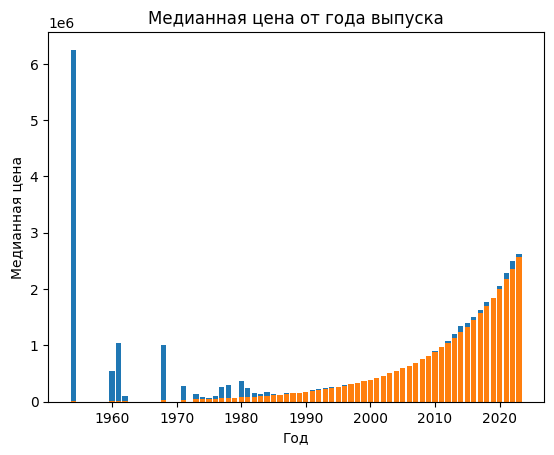

In [ ]:
#plt.bar(year_pivot_table.index, year_pivot_table['mean'])
plt.bar(year_pivot_table.index, year_pivot_table['median'])
plt.bar(year_pivot_table.index, cf_points)
plt.title('Медианная цена от года выпуска')
plt.xlabel('Год')
plt.ylabel('Медианная цена')

По графикам среднего и медианы мы видим странную тенденцию, что старые автомобили стоят крайне дорого. Это вызвано тем, что машины возрастом более 50 лет могут представлять коллекционный интерес: например, Шевроле 3600 1954 года за 6.250.000. В данной модели, такие автомобили будут портить модель, т.к. рынок на них практически отсутствует.

In [ ]:
def get_apprx_point(year, curve_fit):
    return np.exp(curve_fit[1]) * np.exp(curve_fit[0] * year)

In [ ]:
df[df['year'] == 1954]

,year,brand,model,power,transmission,type_of_drive,wheel,color,mileage,wanted,limit,price,Fuel,V,hybrid_or_GBO


Аппроксимировав график экспонентой по значениям медианы с 1985 года, получим некоторый набор контрольных значений. Предположим, что автомобиль, который стоит в 10 раз больше, чем цена для его года (старше 1985 года), обладает некторой раритетной ценностью, поэтому не будет принимать участие в создании модели

In [ ]:
df_c = df.copy()

In [ ]:
df_with_rarity = df[df['year'] < 1985]
df_with_rarity = df_with_rarity[df_with_rarity['price'] > 10 * get_apprx_point(year=df_with_rarity['year'], curve_fit=curve_fit)]

In [ ]:
df_with_rarity

,year,brand,model,power,transmission,type_of_drive,wheel,color,mileage,wanted,limit,price,Fuel,V,hybrid_or_GBO,avg_mileage_per_year


In [ ]:
df

,year,brand,model,power,transmission,type_of_drive,wheel,color,mileage,wanted,limit,price,Fuel,V,hybrid_or_GBO,avg_mileage_per_year
0,2014,audi,a4,170,вариатор,передний,левый,серый,174000,0.0,0.0,1827000.0,бензин,1.8,No,17400.000000
2,2015,audi,a3,110,робот,передний,левый,белый,198609,0.0,0.0,1224000.0,бензин,1.2,No,22067.666667
3,2007,toyota,rav4,152,АКПП,4WD,левый,серебристый,146518,0.0,0.0,1320000.0,бензин,2.0,No,8618.705882
4,2007,lexus,ls460,380,АКПП,задний,левый,черный,16,0.0,0.0,1185000.0,бензин,4.6,No,0.941176
5,2019,audi,a4,249,робот,4WD,левый,белый,52651,0.0,0.0,3597000.0,бензин,2.0,No,10530.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243811,2017,lada,granta,87,механика,передний,левый,белый,190000,0.0,0.0,457000.0,бензин,1.6,ГБО,27142.857143
243813,2006,lada,2112,89,механика,передний,левый,черный,350000,0.0,0.0,170000.0,бензин,1.6,ГБО,19444.444444
243818,2007,hyundai,elantra,122,механика,передний,левый,серый,290000,0.0,0.0,555000.0,бензин,1.6,No,17058.823529
243822,2015,mercedes-benz,amg_gt,510,робот,задний,левый,серый,12000,0.0,0.0,20000000.0,бензин,4.0,No,1333.333333


In [ ]:
df_c = df.drop(index=df_with_rarity.index)


In [ ]:
df_c = df_c[(df_c['mileage'] >= 5000) | (df_c['year'] >= 2013)]

In [ ]:
df_c

,year,brand,model,power,transmission,type_of_drive,wheel,color,mileage,wanted,limit,price,Fuel,V,hybrid_or_GBO,avg_mileage_per_year
0,2014,audi,a4,170,вариатор,передний,левый,серый,174000,0.0,0.0,1827000.0,бензин,1.8,No,17400.000000
2,2015,audi,a3,110,робот,передний,левый,белый,198609,0.0,0.0,1224000.0,бензин,1.2,No,22067.666667
3,2007,toyota,rav4,152,АКПП,4WD,левый,серебристый,146518,0.0,0.0,1320000.0,бензин,2.0,No,8618.705882
5,2019,audi,a4,249,робот,4WD,левый,белый,52651,0.0,0.0,3597000.0,бензин,2.0,No,10530.200000
6,2016,toyota,succeed,109,вариатор,передний,правый,белый,17000,0.0,0.0,880000.0,бензин,1.5,No,2125.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243807,2011,lada,2115,81,механика,передний,левый,белый,133000,0.0,0.0,300000.0,бензин,1.6,No,10230.769231
243811,2017,lada,granta,87,механика,передний,левый,белый,190000,0.0,0.0,457000.0,бензин,1.6,ГБО,27142.857143
243813,2006,lada,2112,89,механика,передний,левый,черный,350000,0.0,0.0,170000.0,бензин,1.6,ГБО,19444.444444
243818,2007,hyundai,elantra,122,механика,передний,левый,серый,290000,0.0,0.0,555000.0,бензин,1.6,No,17058.823529


In [ ]:
year_pivot_table_without_rarity = pd.pivot_table(df_c, index=['year'],
                       aggfunc={'price': ["mean", 'median']})['price']
cf_points_without_rarity = np.exp(curve_fit[1]) * np.exp(curve_fit[0] * year_pivot_table_without_rarity.index)

Text(0, 0.5, 'Медианная цена')

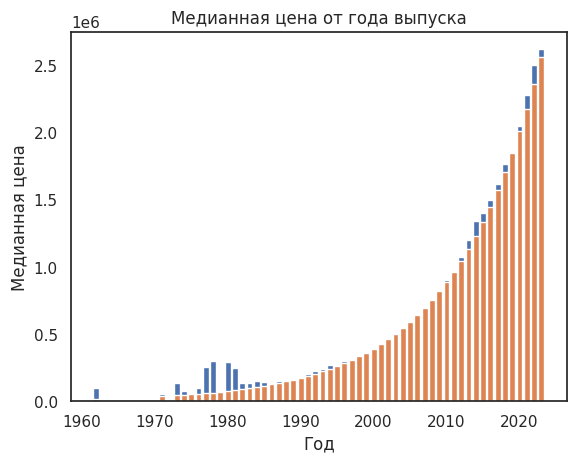

In [ ]:
plt.bar(year_pivot_table_without_rarity.index, year_pivot_table_without_rarity['median'])
plt.bar(year_pivot_table_without_rarity.index, cf_points_without_rarity)
plt.title('Медианная цена от года выпуска')
plt.xlabel('Год')
plt.ylabel('Медианная цена')

Таким образом, была произведена подготовка данных, все переменные имеют правильные типы, а также произведена работа над пропусками

In [ ]:
df_c['price'].nlargest(10)

13884     34000000.0
101458    29999000.0
21542     26500000.0
85139     25000000.0
92844     23300000.0
38893     22999000.0
60837     22000000.0
92487     21000000.0
22325     20855000.0
20754     20500000.0
Name: price, dtype: float64

Введем параметр - средний пробег в год

In [ ]:
df_c['avg_mileage_per_year'] = df_c['mileage'] / (2024 - df['year'])

In [ ]:
df_c

,year,brand,model,power,transmission,type_of_drive,wheel,color,mileage,wanted,limit,price,Fuel,V,hybrid_or_GBO,avg_mileage_per_year
0,2014,audi,a4,170,вариатор,передний,левый,серый,174000,0.0,0.0,1827000.0,бензин,1.8,No,17400.000000
2,2015,audi,a3,110,робот,передний,левый,белый,198609,0.0,0.0,1224000.0,бензин,1.2,No,22067.666667
3,2007,toyota,rav4,152,АКПП,4WD,левый,серебристый,146518,0.0,0.0,1320000.0,бензин,2.0,No,8618.705882
5,2019,audi,a4,249,робот,4WD,левый,белый,52651,0.0,0.0,3597000.0,бензин,2.0,No,10530.200000
6,2016,toyota,succeed,109,вариатор,передний,правый,белый,17000,0.0,0.0,880000.0,бензин,1.5,No,2125.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243807,2011,lada,2115,81,механика,передний,левый,белый,133000,0.0,0.0,300000.0,бензин,1.6,No,10230.769231
243811,2017,lada,granta,87,механика,передний,левый,белый,190000,0.0,0.0,457000.0,бензин,1.6,ГБО,27142.857143
243813,2006,lada,2112,89,механика,передний,левый,черный,350000,0.0,0.0,170000.0,бензин,1.6,ГБО,19444.444444
243818,2007,hyundai,elantra,122,механика,передний,левый,серый,290000,0.0,0.0,555000.0,бензин,1.6,No,17058.823529


In [ ]:
result = df_c.groupby('year').agg({'avg_mileage_per_year': 'mean'})

# Выводим результат
print(result['avg_mileage_per_year'])

year
1962     1290.322581
1971     1811.320755
1973     1575.352941
1974      250.000000
1975      979.591837
1976     1000.000000
1977      115.489362
1978     3260.869565
1979     3717.724444
1980     7045.454545
1981     3074.360465
1982     3808.199405
1983     4208.079823
1984     5108.268103
1985     4964.380220
1986     5275.176842
1987     6920.268963
1988     6508.615137
1989     7066.937458
1990     7229.473856
1991     8460.171086
1992     8505.121011
1993     8464.678988
1994     8947.456418
1995     8490.996025
1996     9555.994969
1997     9462.196719
1998    10509.143841
1999    10554.817925
2000    10771.824286
2001    10858.613103
2002    11063.104633
2003    11264.933642
2004    11703.524554
2005    12195.986714
2006    12325.865913
2007    12646.094478
2008    12983.207855
2009    12262.598377
2010    12805.790022
2011    13278.006893
2012    13623.936074
2013    14052.494374
2014    14216.674276
2015    14794.826386
2016    15111.107029
2017    15255.521258
2018    

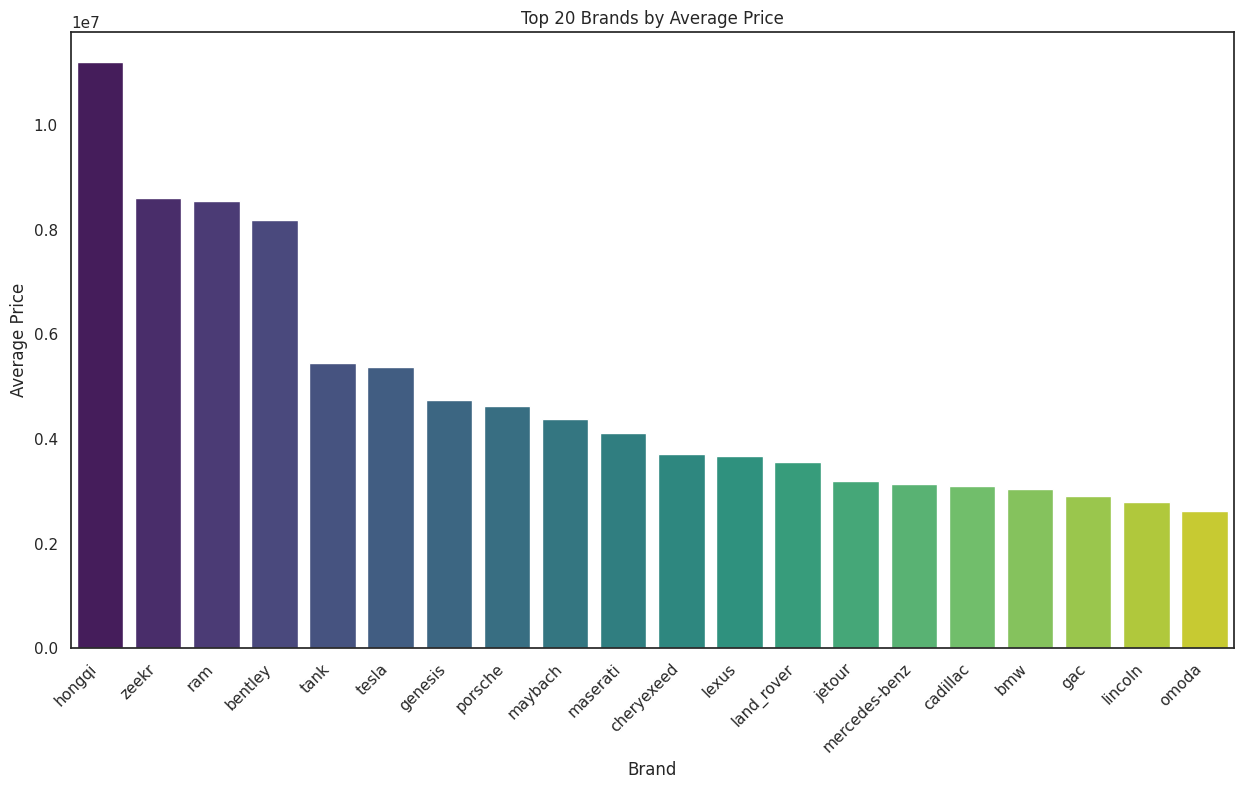

In [ ]:
# Сгруппировать данные по брендам и вычислить среднюю цену
average_price_by_brand = df_c.groupby('brand')['price'].mean().reset_index()

# Отсортировать по средней цене по убыванию и взять топ N
top_n = 20
top_brands = average_price_by_brand.sort_values(by='price', ascending=False).head(top_n)

# Визуализация средней цены по брендам (топ N)
plt.figure(figsize=(15, 8))
sns.barplot(x='brand', y='price', data=top_brands, palette='viridis')
plt.title(f'Top {top_n} Brands by Average Price')
plt.xlabel('Brand')
plt.ylabel('Average Price')
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
top_brands['brand']

39           hongqi
98            zeekr
76              ram
4           bentley
88             tank
89            tesla
31          genesis
75          porsche
61          maybach
60         maserati
12       cheryexeed
55            lexus
54       land_rover
49           jetour
63    mercedes-benz
9          cadillac
5               bmw
28              gac
57          lincoln
69            omoda
Name: brand, dtype: object

In [ ]:
average_price_by_brand = df_c.groupby('brand')['price'].mean().reset_index()

# Отсортировать по средней цене по убыванию и взять топ 20
top_n = 20
top_brands = average_price_by_brand.sort_values(by='price', ascending=False).head(top_n)

# Создать столбец Premium_brand и обозначить бренды в топ-20 как 1, остальные как 0
df_c['Premium_brand'] = df_c['brand'].isin(top_brands['brand']).astype(int)

In [ ]:
df_c

,year,brand,model,power,transmission,type_of_drive,wheel,color,mileage,wanted,limit,price,Fuel,V,hybrid_or_GBO,avg_mileage_per_year,V_category,country,Premium_brand
0,2014,audi,a4,170,вариатор,передний,левый,серый,174000,0.0,0.0,1827000.0,бензин,1.8,No,17400.000000,Medium,Germany,0
2,2015,audi,a3,110,робот,передний,левый,белый,198609,0.0,0.0,1224000.0,бензин,1.2,No,22067.666667,Small,Germany,0
3,2007,toyota,rav4,152,АКПП,4WD,левый,серебристый,146518,0.0,0.0,1320000.0,бензин,2.0,No,8618.705882,Medium,Japan,0
5,2019,audi,a4,249,робот,4WD,левый,белый,52651,0.0,0.0,3597000.0,бензин,2.0,No,10530.200000,Medium,Germany,0
6,2016,toyota,succeed,109,вариатор,передний,правый,белый,17000,0.0,0.0,880000.0,бензин,1.5,No,2125.000000,Small,Japan,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243807,2011,lada,2115,81,механика,передний,левый,белый,133000,0.0,0.0,300000.0,бензин,1.6,No,10230.769231,Medium,Russia,0
243811,2017,lada,granta,87,механика,передний,левый,белый,190000,0.0,0.0,457000.0,бензин,1.6,ГБО,27142.857143,Medium,Russia,0
243813,2006,lada,2112,89,механика,передний,левый,черный,350000,0.0,0.0,170000.0,бензин,1.6,ГБО,19444.444444,Medium,Russia,0
243818,2007,hyundai,elantra,122,механика,передний,левый,серый,290000,0.0,0.0,555000.0,бензин,1.6,No,17058.823529,Medium,South Korea,0


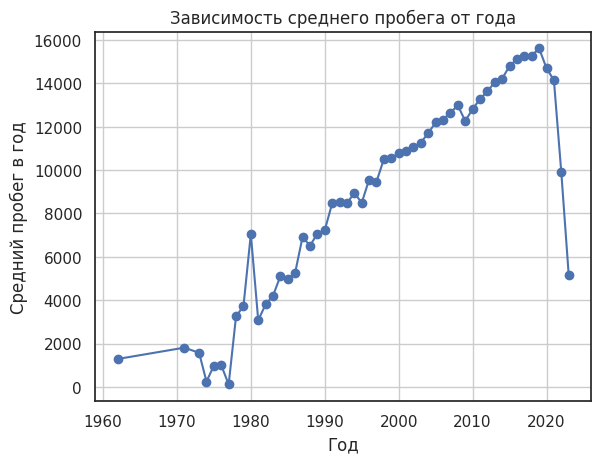

In [ ]:
plt.plot(result.index, result['avg_mileage_per_year'], marker='o')
plt.xlabel('Год')
plt.ylabel('Средний пробег в год')
plt.title('Зависимость среднего пробега от года')
plt.grid(True)
plt.show()

Как мы видим, у машин возрастом 2-12 лет средний пробег больше всего. Это говорит о том, что автомобиль постоянно используется в формате "на каждый день"

In [ ]:
# Находим максимум, минимум и медиану цен
max_price = df['price'].max()
min_price = df['price'].min()
median_price = df['price'].median()

# Выводим результаты
print(f"Максимальная цена: {max_price}")
print(f"Минимальная цена: {min_price}")
print(f"Медианная цена: {median_price}")

Максимальная цена: 34000000.0
Минимальная цена: 21801.0
Медианная цена: 1100000.0


попробуем разделить датасет на 3 части:


1.   Бюджетные (до 1.1 млн.)
2.   Средний класс (1.1 - 5 млн.)
3.   Премиум (5 млн.+)



In [ ]:
# Определение категорий
budget_threshold = 1100000
premium_threshold = 5000000

# Создание нового столбца 'class' для указания категории
df_c['class'] = pd.cut(df['price'], bins=[-float('inf'), budget_threshold, premium_threshold, float('inf')],
                     labels=['Budget', 'Medium', 'Premium'])


In [ ]:
class_counts = df_c['class'].value_counts()
print(class_counts)

Budget     27128
Medium     25487
Premium     1432
Name: class, dtype: int64


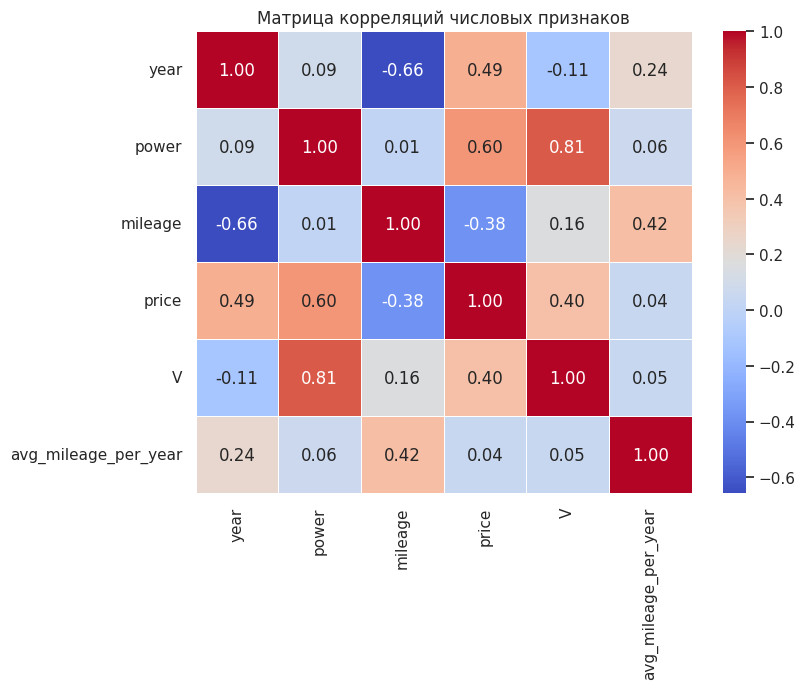

In [ ]:
# Создаем матрицу корреляций
correlation_matrix = df_c.drop(columns=['wanted', 'limit']).corr()

# Используем seaborn для отображения матрицы корреляций
sns.set(style="white")  # Опциональная установка стиля seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Матрица корреляций числовых признаков')
plt.show()

У нас есть пара сильно скоррелированных признаков: мощность и объем двигателя. Попробуем ввести категориальный параметр, который будет дискретизировать размеры двигателя

In [ ]:
df_c = df_c.drop(columns=['V_category'])

In [ ]:
df_c['V_category'] = pd.cut(df_c['V'], bins=[0, 1.5, 3.0, float('inf')], labels=['Small', 'Medium', 'Large'])
df_c

,year,brand,model,power,transmission,type_of_drive,wheel,color,mileage,wanted,limit,price,Fuel,V,hybrid_or_GBO,avg_mileage_per_year,V_category
0,2014,audi,a4,170,вариатор,передний,левый,серый,174000,0.0,0.0,1827000.0,бензин,1.8,No,17400.000000,Medium
2,2015,audi,a3,110,робот,передний,левый,белый,198609,0.0,0.0,1224000.0,бензин,1.2,No,22067.666667,Small
3,2007,toyota,rav4,152,АКПП,4WD,левый,серебристый,146518,0.0,0.0,1320000.0,бензин,2.0,No,8618.705882,Medium
5,2019,audi,a4,249,робот,4WD,левый,белый,52651,0.0,0.0,3597000.0,бензин,2.0,No,10530.200000,Medium
6,2016,toyota,succeed,109,вариатор,передний,правый,белый,17000,0.0,0.0,880000.0,бензин,1.5,No,2125.000000,Small
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243807,2011,lada,2115,81,механика,передний,левый,белый,133000,0.0,0.0,300000.0,бензин,1.6,No,10230.769231,Medium
243811,2017,lada,granta,87,механика,передний,левый,белый,190000,0.0,0.0,457000.0,бензин,1.6,ГБО,27142.857143,Medium
243813,2006,lada,2112,89,механика,передний,левый,черный,350000,0.0,0.0,170000.0,бензин,1.6,ГБО,19444.444444,Medium
243818,2007,hyundai,elantra,122,механика,передний,левый,серый,290000,0.0,0.0,555000.0,бензин,1.6,No,17058.823529,Medium


В нашей стране существует привязанность к стране производителя, поэтому попробуем добавить страну производителя

In [ ]:
np.unique(df_c['brand'])

array(['acura', 'alfa_romeo', 'audi', 'baw', 'bentley', 'bmw', 'bogdan',
       'brilliance', 'byd', 'cadillac', 'changan', 'chery', 'cheryexeed',
       'chevrolet', 'chrysler', 'citroen', 'dacia', 'daewoo', 'daihatsu',
       'datsun', 'dodge', 'dongfeng', 'dw_hower', 'faw', 'fiat', 'ford',
       'forthing', 'foton', 'gac', 'gaz', 'geely', 'genesis', 'geo',
       'gmc', 'great_wall', 'hafei', 'haima', 'haval', 'honda', 'hongqi',
       'hummer', 'hyundai', 'infiniti', 'iran_khodro', 'isuzu', 'izh',
       'jac', 'jaguar', 'jeep', 'jetour', 'jetta', 'kaiyi', 'kia', 'lada',
       'land_rover', 'lexus', 'lifan', 'lincoln', 'luaz', 'luxgen',
       'maserati', 'maybach', 'mazda', 'mercedes-benz', 'mercury', 'mini',
       'mitsubishi', 'moskvitch', 'nissan', 'omoda', 'opel', 'other',
       'peugeot', 'plymouth', 'pontiac', 'porsche', 'ram', 'ravon',
       'renault', 'rover', 'saab', 'seat', 'skoda', 'smart', 'ssang_yong',
       'subaru', 'suzuki', 'tagaz', 'tank', 'tesla', 'tianma'

In [ ]:
# Создаем словарь с соответствиями марок и стран
brand_country_dict = {'acura': 'Japan',
                      'alfa_romeo': 'Italy',
                      'audi': 'Germany',
                      'baw': 'China',
                      'bentley': 'United Kingdom',
                      'bmw': 'Germany',
                      'bogdan': 'Ukraine',
                      'brilliance': 'China',
                      'byd': 'China',
                      'cadillac': 'United States',
                      'changan': 'China',
                      'chery': 'China',
                      'cheryexeed': 'China',
                      'chevrolet': 'United States',
                      'chrysler': 'United States',
                      'citroen': 'France',
                      'dacia': 'Romania',
                      'daewoo': 'South Korea',
                      'daihatsu': 'Japan',
                      'datsun': 'Japan',
                      'dodge': 'United States',
                      'dongfeng': 'China',
                      'dw_hower': 'China',
                      'faw': 'China',
                      'fiat': 'Italy',
                      'ford': 'United States',
                      'forthing': 'China',
                      'foton': 'China',
                      'gac': 'China',
                      'gaz': 'Russia',
                      'geely': 'China',
                      'genesis': 'South Korea',
                      'geo': 'United States',
                      'gmc': 'United States',
                      'great_wall': 'China',
                      'hafei': 'China',
                      'haima': 'China',
                      'haval': 'China',
                      'honda': 'Japan',
                      'hongqi': 'China',
                      'hummer': 'United States',
                      'hyundai': 'South Korea',
                      'infiniti': 'Japan',
                      'iran_khodro': 'Iran',
                      'isuzu': 'Japan',
                      'izh': 'Russia',
                      'jac': 'China',
                      'jaguar': 'United Kingdom',
                      'jeep': 'United States',
                      'jetour': 'China',
                      'jetta': 'Germany',
                      'kaiyi': 'China',
                      'kia': 'South Korea',
                      'lada': 'Russia',
                      'land_rover': 'United Kingdom',
                      'lexus': 'Japan',
                      'lifan': 'China',
                      'lincoln': 'United States',
                      'luaz': 'Ukraine',
                      'luxgen': 'Taiwan',
                      'maserati': 'Italy',
                      'maybach': 'Germany',
                      'mazda': 'Japan',
                      'mercedes-benz': 'Germany',
                      'mercury': 'United States',
                      'mini': 'United Kingdom',
                      'mitsubishi': 'Japan',
                      'moskvitch': 'Russia',
                      'nissan': 'Japan',
                      'omoda': 'China',
                      'opel': 'Germany',
                      'other': 'Other',
                      'peugeot': 'France',
                      'plymouth': 'United States',
                      'pontiac': 'United States',
                      'porsche': 'Germany',
                      'ram': 'United States',
                      'ravon': 'Uzbekistan',
                      'renault': 'France',
                      'rover': 'United Kingdom',
                      'saab': 'Sweden',
                      'seat': 'Spain',
                      'skoda': 'Czech Republic',
                      'smart': 'Germany',
                      'ssang_yong': 'South Korea',
                      'subaru': 'Japan',
                      'suzuki': 'Japan',
                      'tagaz': 'Russia',
                      'tank': 'China',
                      'tesla': 'United States',
                      'tianma': 'China',
                      'tianye': 'China',
                      'toyota': 'Japan',
                      'uaz': 'Russia',
                      'volkswagen': 'Germany',
                      'volvo': 'Sweden',
                      'vortex': 'Russia',
                      'zaz': 'Ukraine',
                      'zeekr': 'China',
                      'zotye': 'China',
                      'zx': 'China'}

# Создаем новый столбец с страной производителя
df_c['country'] = df_c['brand'].map(brand_country_dict)

In [ ]:
def fix_drive_type(value):
    if '4WD' in value:
        return '4WD'
    elif 'AWD' in value:
        return 'AWD'
    elif 'RWD' in value:
        return 'задний'
    elif 'FWD' in value:
        return 'передний'
    else:
        return value

In [ ]:
df_c['type_of_drive'] = df_c['type_of_drive'].apply(fix_drive_type)

In [ ]:
df_c

,year,brand,model,power,transmission,type_of_drive,wheel,color,mileage,wanted,limit,price,Fuel,V,hybrid_or_GBO,avg_mileage_per_year,country,Premium_brand
0,2014,audi,a4,170,вариатор,передний,левый,серый,174000,0.0,0.0,1827000.0,бензин,1.8,No,17400.000000,Germany,0
2,2015,audi,a3,110,робот,передний,левый,белый,198609,0.0,0.0,1224000.0,бензин,1.2,No,22067.666667,Germany,0
3,2007,toyota,rav4,152,АКПП,4WD,левый,серебристый,146518,0.0,0.0,1320000.0,бензин,2.0,No,8618.705882,Japan,0
5,2019,audi,a4,249,робот,4WD,левый,белый,52651,0.0,0.0,3597000.0,бензин,2.0,No,10530.200000,Germany,0
6,2016,toyota,succeed,109,вариатор,передний,правый,белый,17000,0.0,0.0,880000.0,бензин,1.5,No,2125.000000,Japan,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243807,2011,lada,2115,81,механика,передний,левый,белый,133000,0.0,0.0,300000.0,бензин,1.6,No,10230.769231,Russia,0
243811,2017,lada,granta,87,механика,передний,левый,белый,190000,0.0,0.0,457000.0,бензин,1.6,ГБО,27142.857143,Russia,0
243813,2006,lada,2112,89,механика,передний,левый,черный,350000,0.0,0.0,170000.0,бензин,1.6,ГБО,19444.444444,Russia,0
243818,2007,hyundai,elantra,122,механика,передний,левый,серый,290000,0.0,0.0,555000.0,бензин,1.6,No,17058.823529,South Korea,0


In [ ]:
# Создание столбца 'tax_rate' на основе значения 'power'
df_c['tax_rate'] = df_c['power'].apply(lambda x: 2.5 if x < 100 else (3.5 if x < 150 else (5 if x < 250 else 7.5)))

# Вывод обновленного DataFrame
print(df_c.head())


   year   brand    model  power transmission type_of_drive   wheel  \
0  2014    audi       a4    170     вариатор      передний   левый   
2  2015    audi       a3    110        робот      передний   левый   
3  2007  toyota     rav4    152         АКПП           4WD   левый   
5  2019    audi       a4    249        робот           4WD   левый   
6  2016  toyota  succeed    109     вариатор      передний  правый   

         color  mileage  wanted  limit      price    Fuel    V hybrid_or_GBO  \
0        серый   174000     0.0    0.0  1827000.0  бензин  1.8            No   
2        белый   198609     0.0    0.0  1224000.0  бензин  1.2            No   
3  серебристый   146518     0.0    0.0  1320000.0  бензин  2.0            No   
5        белый    52651     0.0    0.0  3597000.0  бензин  2.0            No   
6        белый    17000     0.0    0.0   880000.0  бензин  1.5            No   

   avg_mileage_per_year  country  Premium_brand  tax_rate  
0          17400.000000  Germany      

In [ ]:
df_c.to_csv('final.csv')

In [ ]:
np.unique(df_c['type_of_drive'])

array(['4WD', 'задний', 'передний'], dtype=object)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
rs = 14

In [ ]:
def show_metrics(pred, test):
    mse = mean_squared_error(pred, test)
    mape = mean_absolute_percentage_error(pred, test)
    r2 = r2_score(pred, test)

    print(f'Среднеквадратичная ошибка (Mean Squared Error): {mse}')
    print(f'Root mean Squared Error): {np.sqrt(mse)}')
    print(f'Средняя абсолютная процентная ошибка (Mean Absolute Percentage Error): {mape}')
    print(f'R-квадрат: {r2}')

In [ ]:
df1=df_c.copy()

In [ ]:
df1.columns

Index(['year', 'brand', 'model', 'power', 'transmission', 'type_of_drive',
       'wheel', 'color', 'mileage', 'wanted', 'limit', 'price', 'Fuel', 'V',
       'hybrid_or_GBO', 'avg_mileage_per_year', 'country', 'Premium_brand',
       'tax_rate'],
      dtype='object')

# OHE

In [ ]:
columns_to_encode = [ 'brand', 'model', 'transmission', 'type_of_drive', 'wheel', 'color', 'Fuel', 'hybrid_or_GBO',
       'country']
df1 = pd.get_dummies(df1, columns= columns_to_encode, drop_first= True)
df1

,year,power,mileage,wanted,limit,price,V,avg_mileage_per_year,Premium_brand,tax_rate,...,country_Romania,country_Russia,country_South Korea,country_Spain,country_Sweden,country_Taiwan,country_Ukraine,country_United Kingdom,country_United States,country_Uzbekistan
0,2014,170,174000,0.0,0.0,1827000.0,1.8,17400.000000,0,5.0,...,0,0,0,0,0,0,0,0,0,0
2,2015,110,198609,0.0,0.0,1224000.0,1.2,22067.666667,0,3.5,...,0,0,0,0,0,0,0,0,0,0
3,2007,152,146518,0.0,0.0,1320000.0,2.0,8618.705882,0,5.0,...,0,0,0,0,0,0,0,0,0,0
5,2019,249,52651,0.0,0.0,3597000.0,2.0,10530.200000,0,5.0,...,0,0,0,0,0,0,0,0,0,0
6,2016,109,17000,0.0,0.0,880000.0,1.5,2125.000000,0,3.5,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243807,2011,81,133000,0.0,0.0,300000.0,1.6,10230.769231,0,2.5,...,0,1,0,0,0,0,0,0,0,0
243811,2017,87,190000,0.0,0.0,457000.0,1.6,27142.857143,0,2.5,...,0,1,0,0,0,0,0,0,0,0
243813,2006,89,350000,0.0,0.0,170000.0,1.6,19444.444444,0,2.5,...,0,1,0,0,0,0,0,0,0,0
243818,2007,122,290000,0.0,0.0,555000.0,1.6,17058.823529,0,3.5,...,0,0,1,0,0,0,0,0,0,0


In [ ]:
X = df1.drop('price', axis=1)
y = df1['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rs)

# Нормализация данных
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)


In [ ]:
np.unique(df_c['type_of_drive'])

array(['4WD', 'задний', 'передний'], dtype=object)

# Linear regression

In [ ]:
# Линейная регрессия
linear_model = LinearRegression()

# Нормализация данных
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

linear_model.fit(X_train_normalized, y_train)
# Оценка моделей
predict = linear_model.predict(X_test_normalized)

show_metrics(predict, y_test)

Среднеквадратичная ошибка (Mean Squared Error): 3.9616810712045943e+37
Root mean Squared Error): 6.294188646048508e+18
Средняя абсолютная процентная ошибка (Mean Absolute Percentage Error): 1.6402974277731759
R-квадрат: -2.0630664221421569e-07


На самом деле, было очевидно, что линейная регрессия не сработает. Лучшими методами для работы с табличными данными являются различные методы деревьев и CatBoost. Попробуем реализовать их и получить результаты

#Random Forest

In [ ]:
show_metrics(rf_pred, y_test)

Среднеквадратичная ошибка (Mean Squared Error): 94745414708.20532
Root mean Squared Error): 307807.4312101729
Средняя абсолютная процентная ошибка (Mean Absolute Percentage Error): 0.1332432335108791
R-квадрат: 0.9578718156341577


Результат уже неплохой, но попробуем поиграть гиперпараметрами:

Видно, что необходимо около 150 эстиматоров, но можно попробовать увеличить глубину деревьев

In [ ]:
rf_model = RandomForestRegressor(n_estimators=150,random_state=rs)
rf_model.fit(X_train_normalized, y_train)
rf_pred = rf_model.predict(X_test_normalized)


In [ ]:
show_metrics(rf_pred, y_test)

Среднеквадратичная ошибка (Mean Squared Error): 110281830627.9125
Root mean Squared Error): 332087.0828983153
Средняя абсолютная процентная ошибка (Mean Absolute Percentage Error): 0.14613338500031955
R-квадрат: 0.9498444656081114


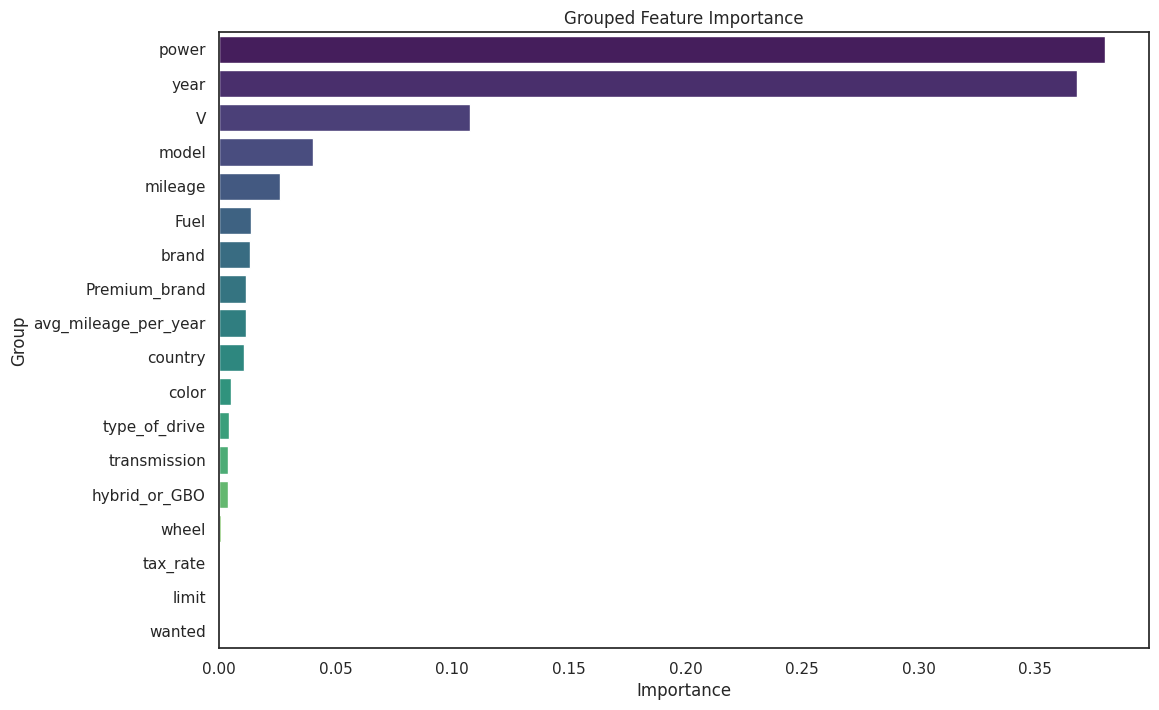

In [ ]:

# Получение важности признаков
feature_importance = rf_model.feature_importances_

# Создание DataFrame для удобства визуализации
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})

# Создаем новый столбец для группировки
feature_importance_df['Group'] = feature_importance_df['Feature'].apply(lambda x: next((col for col in columns_to_encode if x.startswith(col)), x))

# Группируем и суммируем важности по новому столбцу 'Group'
grouped_importance = feature_importance_df.groupby('Group')['Importance'].sum().reset_index()

# Сортировка по важности
grouped_importance = grouped_importance.sort_values(by='Importance', ascending=False)

# Визуализация важности признаков
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Group', data=grouped_importance, palette='viridis')
plt.title('Grouped Feature Importance')
plt.show()


In [ ]:
rf_model = RandomForestRegressor(n_estimators=150,random_state=rs)
rf_model.fit(X_train_normalized, y_train)
rf_pred = rf_model.predict(X_test_normalized)
show_metrics(rf_pred, y_test)

Среднеквадратичная ошибка (Mean Squared Error): 110449814900.12338
Root mean Squared Error): 332339.9086780331
Средняя абсолютная процентная ошибка (Mean Absolute Percentage Error): 0.14600783013958543
R-квадрат: 0.9496803460128177


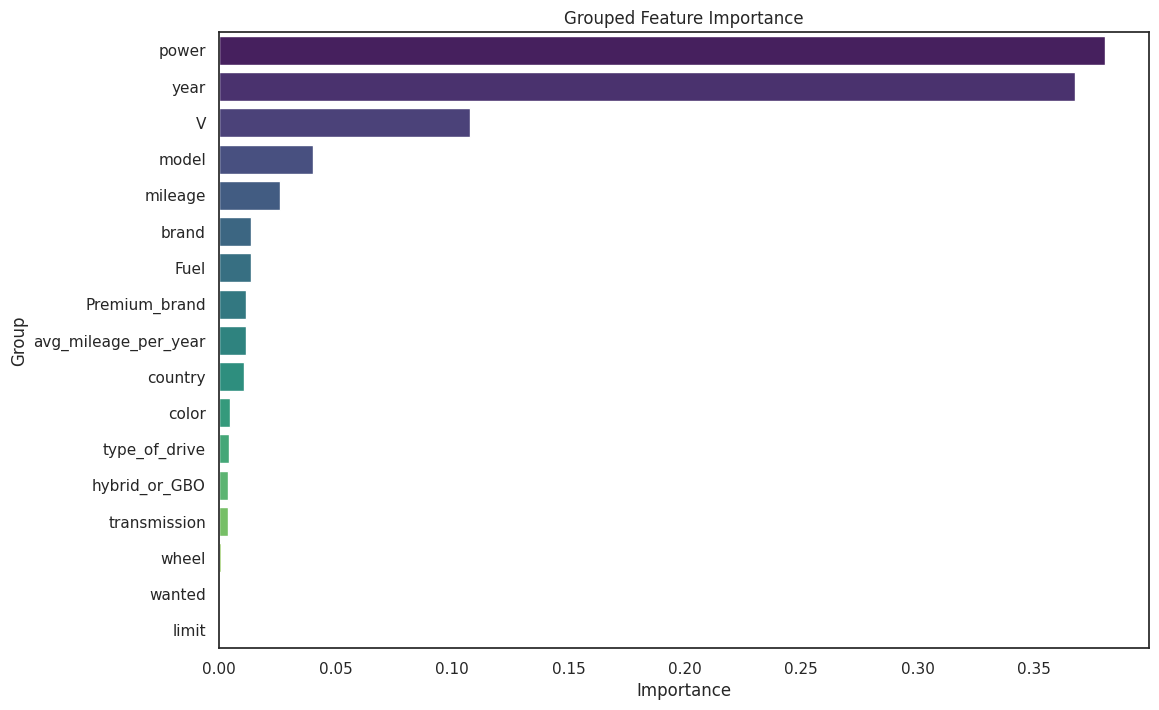

In [ ]:

# Получение важности признаков
feature_importance = rf_model.feature_importances_

# Создание DataFrame для удобства визуализации
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})

# Создаем новый столбец для группировки
feature_importance_df['Group'] = feature_importance_df['Feature'].apply(lambda x: next((col for col in columns_to_encode if x.startswith(col)), x))

# Группируем и суммируем важности по новому столбцу 'Group'
grouped_importance = feature_importance_df.groupby('Group')['Importance'].sum().reset_index()

# Сортировка по важности
grouped_importance = grouped_importance.sort_values(by='Importance', ascending=False)

# Визуализация важности признаков
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Group', data=grouped_importance, palette='viridis')
plt.title('Grouped Feature Importance')
plt.show()

#Gradient Boosting

In [ ]:
# Создание модели GradientBoostingRegressor со стандартными параметрами
gb_model_default = GradientBoostingRegressor(random_state=rs)

# Обучение модели
gb_model_default.fit(X_train_normalized, y_train)

# Предсказание
gb_pred_default = gb_model_default.predict(X_test_normalized)

In [ ]:
show_metrics(gb_pred_default, y_test)

Среднеквадратичная ошибка (Mean Squared Error): 183564406153.5914
Root mean Squared Error): 428444.1692374765
Средняя абсолютная процентная ошибка (Mean Absolute Percentage Error): 0.21415282200508481
R-квадрат: 0.9102620853889881


In [ ]:
# Визуализация важности признаков
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance')
plt.show()

In [ ]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.5 MB/s eta 0:00:00


Для Cat boost будем использовать массив до OHE.

In [ ]:
from catboost import CatBoostRegressor
from catboost import Pool, cv
from pandas.api.types import is_numeric_dtype
import catboost as cb

In [ ]:
df_cat = df_c.copy()

In [ ]:
df_cat.isna().sum()

year                    0
brand                   0
model                   0
power                   0
transmission            0
type_of_drive           0
wheel                   0
color                   0
mileage                 0
wanted                  0
limit                   0
price                   0
Fuel                    0
V                       0
hybrid_or_GBO           0
avg_mileage_per_year    0
country                 0
Premium_brand           0
dtype: int64

In [ ]:
def get_categorical_indicies(X):
    cats = []
    for col in X.columns:
        if is_numeric_dtype(X[col]):
            pass
        else:
            cats.append(col)
    cat_indicies = []
    for col in cats:
        cat_indicies.append(X.columns.get_loc(col))
    return cat_indicies

In [ ]:
def convert_cats(X):
    cats = []
    for col in X.columns:
        if is_numeric_dtype(X[col]):
            pass
        else:
            cats.append(col)
    cat_indicies = []
    for col in cats:
        X[col] = X[col].astype('category')


In [ ]:
# Подготовка данных
X = df_cat.drop('price', axis=1)
y = df_cat['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rs)

# Нормализация числовых признаков
numeric_features = X.select_dtypes(include=['number']).columns
scaler = StandardScaler()
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

# Преобразование категориальных признаков
convert_cats(X_train)
convert_cats(X_test)

In [ ]:
categorical_indices = get_categorical_indicies(X_train)
model = CatBoostRegressor(iterations=1000,
                          learning_rate=0.01,
                          depth=10)
model.fit(X_train, y_train, verbose=True, cat_features=categorical_indices)


In [ ]:
preds_class = model.predict(X_test)

In [ ]:
show_metrics(preds_class, y_test)

Среднеквадратичная ошибка (Mean Squared Error): 133992675875.49171
Root mean Squared Error): 366050.100226037
Средняя абсолютная процентная ошибка (Mean Absolute Percentage Error): 0.17107382638931132
R-квадрат: 0.9387120014856215


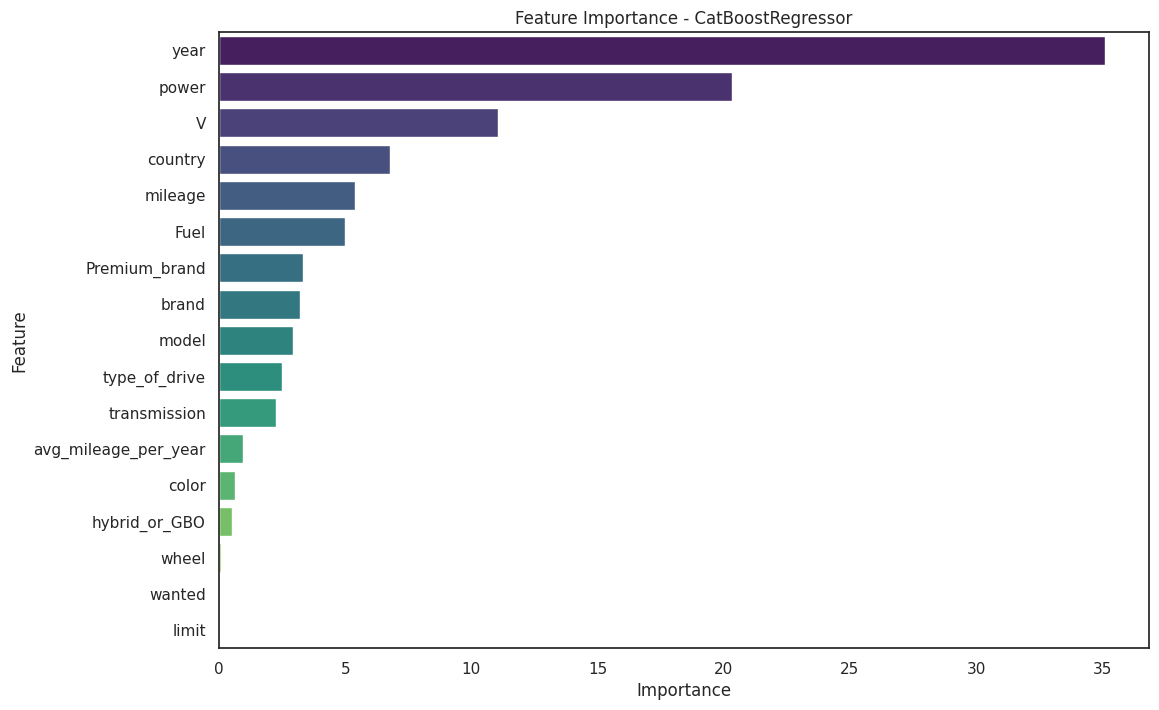

In [ ]:
# Получение важности признаков
feature_importance = model.feature_importances_

# Создание DataFrame для удобства визуализации
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

# Сортировка по важности
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Визуализация важности признаков
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance - CatBoostRegressor')
plt.show()

In [ ]:
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import GridSearchCV, train_test_split

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание Pool объекта для CatBoost
train_pool = Pool(X_train, label=y_train, cat_features=categorical_indices)

# Создание экземпляра модели
model = CatBoostRegressor()

# Словарь с гиперпараметрами для GridSearchCV
param_grid = {'depth': [4, 6, 8],
              'learning_rate': [0.01, 0.1, 0.2],
              'iterations': [50, 100, 200, 500, 1000]}

# Создание объекта GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error')

# Запуск GridSearchCV
grid_search.fit(X_train, y_train, cat_features=categorical_indices)

# Получение лучших параметров
best_params = grid_search.best_params_

# Создание и обучение модели с лучшими параметрами
best_model = CatBoostRegressor(iterations=best_params['iterations'],
                               learning_rate=best_params['learning_rate'],
                               depth=best_params['depth'])
best_model.fit(X_train, y_train, cat_features=categorical_indices)



Выходные данные были обрезаны до нескольких последних строк (5000).
0:	learn: 1293687.8164624	total: 81.4ms	remaining: 1m 21s
1:	learn: 1114444.8827851	total: 170ms	remaining: 1m 24s
2:	learn: 975430.6390263	total: 252ms	remaining: 1m 23s
3:	learn: 862834.7856654	total: 334ms	remaining: 1m 23s
4:	learn: 770675.4847998	total: 413ms	remaining: 1m 22s
5:	learn: 700240.9315209	total: 493ms	remaining: 1m 21s
6:	learn: 647862.8166655	total: 580ms	remaining: 1m 22s
7:	learn: 601402.1308062	total: 656ms	remaining: 1m 21s
8:	learn: 565522.9207922	total: 740ms	remaining: 1m 21s
9:	learn: 534694.9381246	total: 824ms	remaining: 1m 21s
10:	learn: 512159.9107032	total: 901ms	remaining: 1m 21s
11:	learn: 493795.1958450	total: 964ms	remaining: 1m 19s
12:	learn: 477213.8716529	total: 1.03s	remaining: 1m 18s
13:	learn: 464478.7256893	total: 1.1s	remaining: 1m 17s
14:	learn: 452819.1995153	total: 1.17s	remaining: 1m 16s
15:	learn: 444168.2962066	total: 1.23s	remaining: 1m 15s
16:	learn: 436450.5305988	to

In [ ]:
best_preds_class = best_model.predict(X_test)

In [ ]:
show_metrics(best_preds_class, y_test)

Среднеквадратичная ошибка (Mean Squared Error): 118807439537.90208
Root mean Squared Error): 344684.5507676578
Средняя абсолютная процентная ошибка (Mean Absolute Percentage Error): 0.1574265038428256
R-квадрат: 0.944801217594736


In [ ]:
new_model = CatBoostRegressor(iterations=best_params['iterations'],
                               learning_rate=best_params['learning_rate'],
                               depth=best_params['depth'])
new_model.fit(X_train, y_train, cat_features=categorical_indices)

0:	learn: 1409956.4704666	total: 215ms	remaining: 3m 34s
1:	learn: 1304912.5968926	total: 464ms	remaining: 3m 51s
2:	learn: 1212230.3330586	total: 648ms	remaining: 3m 35s
3:	learn: 1130286.7971879	total: 880ms	remaining: 3m 39s
4:	learn: 1056632.0736061	total: 1.12s	remaining: 3m 42s
5:	learn: 988609.9946158	total: 1.29s	remaining: 3m 34s
6:	learn: 927234.9925207	total: 1.51s	remaining: 3m 34s
7:	learn: 873264.2327340	total: 1.72s	remaining: 3m 33s
8:	learn: 825598.7685601	total: 1.94s	remaining: 3m 34s
9:	learn: 782869.1552529	total: 2.12s	remaining: 3m 30s
10:	learn: 744117.4174839	total: 2.37s	remaining: 3m 33s
11:	learn: 710396.3337251	total: 2.58s	remaining: 3m 32s
12:	learn: 681062.1430603	total: 2.78s	remaining: 3m 30s
13:	learn: 653745.3374664	total: 2.99s	remaining: 3m 30s
14:	learn: 628780.0725669	total: 3.17s	remaining: 3m 28s
15:	learn: 605398.4937142	total: 3.29s	remaining: 3m 22s
16:	learn: 586692.0414453	total: 3.38s	remaining: 3m 15s
17:	learn: 568303.9853602	total: 3.4

In [ ]:
new_preds_class = new_model.predict(X_test)
show_metrics(new_preds_class, y_test)

Среднеквадратичная ошибка (Mean Squared Error): 105528442002.00731
Root mean Squared Error): 324851.4152685921
Средняя абсолютная процентная ошибка (Mean Absolute Percentage Error): 0.15587890317110434
R-квадрат: 0.9532586728103072


In [ ]:
best_params

{'depth': 8, 'iterations': 1000, 'learning_rate': 0.1}

In [ ]:
df_exp = pd.read_csv('final.csv')

#Попробуем разделить датасет по году, и проверить, как будут работать модели отдельно на этих датасетах

In [ ]:
df_exp

,Unnamed: 0,year,brand,model,power,transmission,type_of_drive,wheel,color,mileage,wanted,limit,price,Fuel,V,hybrid_or_GBO,avg_mileage_per_year,country,Premium_brand,tax_rate
0,0,2014,audi,a4,170,вариатор,передний,левый,серый,174000,0.0,0.0,1827000.0,бензин,1.8,No,17400.000000,Germany,0,5.0
1,2,2015,audi,a3,110,робот,передний,левый,белый,198609,0.0,0.0,1224000.0,бензин,1.2,No,22067.666667,Germany,0,3.5
2,3,2007,toyota,rav4,152,АКПП,4WD,левый,серебристый,146518,0.0,0.0,1320000.0,бензин,2.0,No,8618.705882,Japan,0,5.0
3,5,2019,audi,a4,249,робот,4WD,левый,белый,52651,0.0,0.0,3597000.0,бензин,2.0,No,10530.200000,Germany,0,5.0
4,6,2016,toyota,succeed,109,вариатор,передний,правый,белый,17000,0.0,0.0,880000.0,бензин,1.5,No,2125.000000,Japan,0,3.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54042,243807,2011,lada,2115,81,механика,передний,левый,белый,133000,0.0,0.0,300000.0,бензин,1.6,No,10230.769231,Russia,0,2.5
54043,243811,2017,lada,granta,87,механика,передний,левый,белый,190000,0.0,0.0,457000.0,бензин,1.6,ГБО,27142.857143,Russia,0,2.5
54044,243813,2006,lada,2112,89,механика,передний,левый,черный,350000,0.0,0.0,170000.0,бензин,1.6,ГБО,19444.444444,Russia,0,2.5
54045,243818,2007,hyundai,elantra,122,механика,передний,левый,серый,290000,0.0,0.0,555000.0,бензин,1.6,No,17058.823529,South Korea,0,3.5


In [ ]:
# Найдем медианный год
median_year = df_exp['year'].median()

# Разделим DataFrame на два: df_old и df_new
df_new = df_exp[df_exp['year'] > median_year]
df_old = df_exp[df_exp['year'] <= median_year]

# Вывод обновленных DataFrame
print("df_old:")
print(df_old.head())
print("\ndf_new:")
print(df_new.head())

df_old:
   Unnamed: 0  year   brand   model  power transmission type_of_drive  wheel  \
2           3  2007  toyota    rav4    152         АКПП           4WD  левый   
5           7  1991    audi      80     90     механика      передний  левый   
7          12  2008    opel   astra    115     механика      передний  левый   
8          13  2008    audi      a6    177     вариатор      передний  левый   
9          15  2013    lada  largus     84     механика      передний  левый   

         color  mileage  wanted  limit      price    Fuel    V hybrid_or_GBO  \
2  серебристый   146518     0.0    0.0  1320000.0  бензин  2.0            No   
5   коричневый   380000     0.0    0.0   140000.0  бензин  2.0            No   
7       черный   260089     0.0    0.0   394000.0  бензин  1.6            No   
8      красный   251600     0.0    0.0   890000.0  бензин  2.4            No   
9        белый   189000     0.0    0.0   499000.0  бензин  1.6            No   

   avg_mileage_per_year  count

In [ ]:
median_year

2013.0

In [ ]:
columns_to_encode = [ 'brand', 'model', 'transmission', 'type_of_drive', 'wheel', 'color', 'Fuel', 'hybrid_or_GBO',
       'country']
df_new = pd.get_dummies(df_new, columns= columns_to_encode, drop_first= True)
df_old = pd.get_dummies(df_old, columns= columns_to_encode, drop_first= True)

In [ ]:
Xn = df_new.drop('price', axis=1)
yn = df_new['price']
Xn_train, Xn_test, yn_train, yn_test = train_test_split(Xn, yn, test_size=0.2, random_state=rs)

Xo = df_old.drop('price', axis=1)
yo = df_old['price']
Xo_train, Xo_test, yo_train, yo_test = train_test_split(Xo, yo, test_size=0.2, random_state=rs)
# Нормализация данных
scaler_new = StandardScaler()
Xn_train_normalized = scaler_new.fit_transform(Xn_train)
Xn_test_normalized = scaler_new.transform(Xn_test)

scaler_old = StandardScaler()
Xo_train_normalized = scaler_old.fit_transform(Xo_train)
Xo_test_normalized = scaler_old.transform(Xo_test)

In [ ]:
rf_new_model = RandomForestRegressor(n_estimators=150,random_state=rs)
rf_new_model.fit(Xn_train_normalized, yn_train)



ValueError: ignored

In [ ]:
rf_pred_new = rf_new_model.predict(Xn_test_normalized)

In [ ]:
show_metrics(rf_pred_new, yn_test)

Среднеквадратичная ошибка (Mean Squared Error): 223179378960.25543
Root mean Squared Error): 472418.6479810629
Средняя абсолютная процентная ошибка (Mean Absolute Percentage Error): 0.09603867526115824
R-квадрат: 0.9274659702281631


In [ ]:
np.unique(feature_importance_df['Importance'])

array([0.])

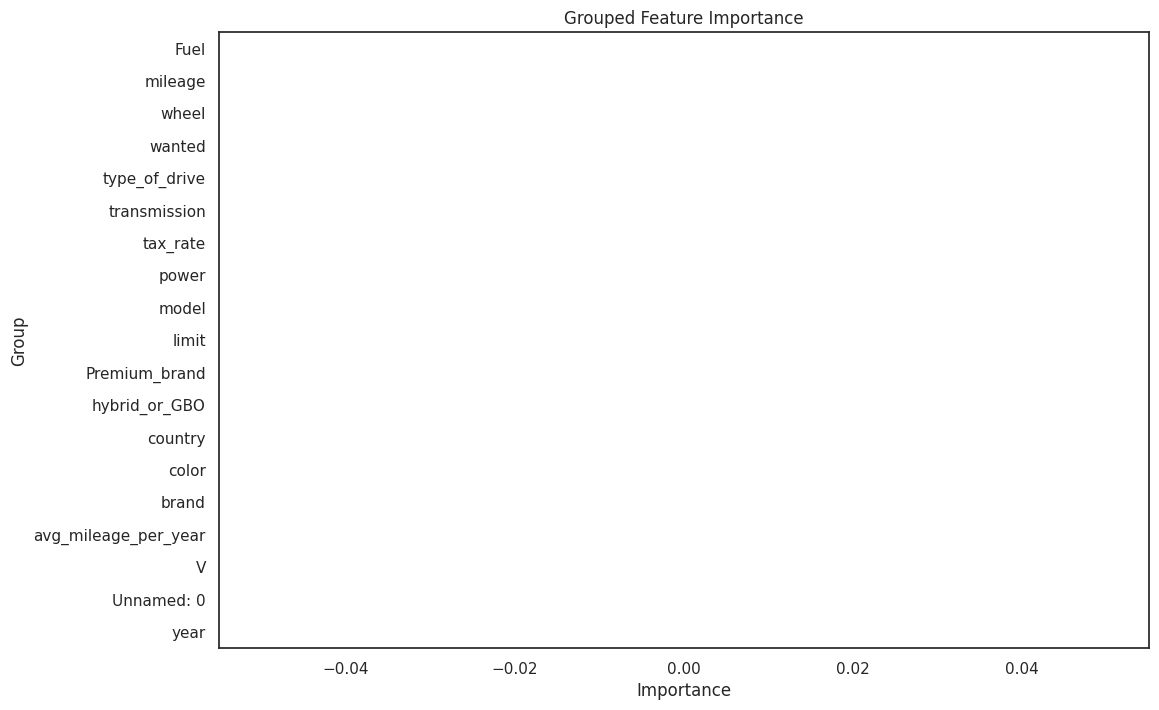

In [ ]:
# Получение важности признаков
feature_importance = rf_new_model.feature_importances_

# Создание DataFrame для удобства визуализации
feature_importance_df = pd.DataFrame({'Feature': Xn_train.columns, 'Importance': feature_importance})

# Создаем новый столбец для группировки
feature_importance_df['Group'] = feature_importance_df['Feature'].apply(lambda x: next((col for col in columns_to_encode if x.startswith(col)), x))

# Группируем и суммируем важности по новому столбцу 'Group'
grouped_importance = feature_importance_df.groupby('Group')['Importance'].sum().reset_index()

# Сортировка по важности
grouped_importance = grouped_importance.sort_values(by='Importance', ascending=False)

# Визуализация важности признаков
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Group', data=grouped_importance, palette='viridis')
plt.title('Grouped Feature Importance')
plt.show()


In [ ]:
rf_old_model = RandomForestRegressor(n_estimators=150,random_state=rs)
rf_old_model.fit(Xo_train_normalized, yo_train)
rf_pred_old= rf_old_model.predict(Xo_test_normalized)
show_metrics(rf_pred_old, yo_test)

Среднеквадратичная ошибка (Mean Squared Error): 62590994362.493195
Root mean Squared Error): 250181.9225333701
Средняя абсолютная процентная ошибка (Mean Absolute Percentage Error): 0.19871799257316494
R-квадрат: 0.8518067371829086
